In [1]:
import pandas as pd, numpy as np
#from shapely.geometry import Polygon
#from shapely.geometry import Point
#import geopandas

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

from sklearn.cluster import DBSCAN

## First we have to load the datasets and merge them

First dataset is the tract data
Second dataset is the data with all of the station-census tract matches

In [2]:
path = 'Output/' # select folder with data in it

#specify datatypes so FIPS numbers, etc. read in properly
dtypes = {'Geo_STATE': 'str', 'Geo_FIPS': 'str', 'Geo_COUNTY': 'str', 'h_tract': 'str', 'FIPS_County': 'str'}

tract_data = pd.read_csv(path + 'tract_data.csv', delimiter=',', dtype=dtypes)

tract_data.head(1)

,Unnamed: 0,Geo_FIPS,alljobs,ltbajobs,lt40kjobs,county_labor,county_unemp,county_med_rent,county_med_value,CBSA Code,...,bach_degree,pop_over_25,hh_kids,total_hh,med_rent,med_housevalue,unemp_civ,civ_labor_force,area_sqmi,HU_density
0,0,06001400100,763651.0,358749.0,301972.0,862353,61327,1432,593500,41860.0,...,1981.0,2478.0,241.0,1292.0,3202.0,1074100.0,75,1643,2.657,486.262695


In [3]:
#specify datatypes so FIPS numbers, etc. read in properly
dtypes2 = {'GEOID': 'str', 'Agency': 'str', 'Stop ID': 'str'}

station_data = pd.read_csv(path + 'best_matches.csv', delimiter=',', dtype=dtypes2)

station_small = station_data[['GEOID','Agency','Stop ID','station_area','tract_area','geometry','overlap_area','key','mode']]
station_small.head(1)

,GEOID,Agency,Stop ID,station_area,tract_area,geometry,overlap_area,key,mode
0,06043000400,Yosemite Valley Shuttle System,766882,0.507711,1025.605497,"POLYGON ((801245.0431922717 4182865.720460022,...",0.507711,Yosemite Valley Shuttle System766882,bus


### Merge the census tract characteristics onto the stations dataset then sum and average across the stations

In [4]:
#merge together datasets by census tract
merge_data = pd.merge(station_small, tract_data, left_on="GEOID", right_on="Geo_FIPS", how="left")
merge_data.head(2)

,GEOID,Agency,Stop ID,station_area,tract_area,geometry,overlap_area,key,mode,Unnamed: 0,...,bach_degree,pop_over_25,hh_kids,total_hh,med_rent,med_housevalue,unemp_civ,civ_labor_force,area_sqmi,HU_density
0,06043000400,Yosemite Valley Shuttle System,766882,0.507711,1025.605497,"POLYGON ((801245.0431922717 4182865.720460022,...",0.507711,Yosemite Valley Shuttle System766882,bus,3601,...,568.0,1579.0,175.0,520.0,533.0,363100.0,108,1466,394.127991,1.319368
1,06071009910,Victor Valley Transit Authority,813390,0.507711,4.403783,"POLYGON ((1019267.173736518 3829647.657939956,...",0.440581,Victor Valley Transit Authority813390,bus,5581,...,283.0,3153.0,637.0,1378.0,1264.0,142400.0,365,2332,1.693000,813.939758


In [5]:
#May want to switch this to a weighted average from a simple average
#wm = lambda x: np.average(x, weights=merge_data.loc[x.index, "total_pop"])

avg_cols = ['alljobs','county_med_rent','med_rent']

stop_avgs=merge_data[avg_cols].groupby(merge_data['key']).mean()

stop_avgs.head()

,alljobs,county_med_rent,med_rent
key,,,
AC Transit1000340,1065622.0,1432,770.0
AC Transit1000350,1065622.0,1432,770.0
AC Transit1000370,1065622.0,1432,770.0
AC Transit1000380,1065622.0,1432,770.0
AC Transit1000410,1075287.0,1432,855.0


In [6]:
sum_cols = ['renters', 'occ_HU', 'hispanic', 'black',
       'white', 'asian', 'nhpi', 'total_pop', 'below200pov',
       'total_pov_status', 'rent_occ_HU', 'low_inc_rent_burden',
       'white_pov_tot', 'white_pov', 'black_pov_tot', 'black_pov',
       'asian_pov_tot', 'asian_pov', 'nhpi_pov_tot', 'nhpi_pov',
       'hispanic_pov_tot', 'hispanic_pov', 'sfdetach', 'smallmf', 'medmf',
       'bigmf', 'total_hu', 'vacant_hu', 'total_hu2', 'since2000',
       'before1950', 'total_structure', 'bach_degree', 'pop_over_25',
       'hh_kids', 'total_hh','unemp_civ','civ_labor_force','area_sqmi']

stop_tots=merge_data[sum_cols].groupby(merge_data['key']).sum()

stop_stats = pd.DataFrame(stop_tots.iloc[:,7])

stop_stats['rent_comp'] = stop_avgs['med_rent'] / stop_avgs['county_med_rent']
stop_stats['jobs'] = stop_avgs['alljobs']

stop_stats['pct_rent']=stop_tots['renters'] / stop_tots['occ_HU']

stop_stats['pct_white']=stop_tots['white'] / stop_tots['total_pop']
stop_stats['pct_hispanic']=stop_tots['hispanic'] / stop_tots['total_pop']
stop_stats['pct_black']=stop_tots['black'] / stop_tots['total_pop']
stop_stats['pct_asian']=stop_tots['asian'] / stop_tots['total_pop']

stop_stats['pct_below200pov']=stop_tots['below200pov'] / stop_tots['total_pov_status']

stop_stats['hispanic_pov']=stop_tots['hispanic_pov'] / stop_tots['hispanic_pov_tot']
for i in list(range(1,len(stop_tots))):
    if stop_tots.iloc[i,2] <= 5 and stop_tots.iloc[i,20]==0:
        stop_stats.iloc[i,9] = 0
stop_stats['black_pov']=stop_tots['black_pov'] / stop_tots['black_pov_tot']
for i in list(range(1,len(stop_tots))):
    if stop_tots.iloc[i,3] <= 5 and stop_tots.iloc[i,14]==0:
        stop_stats.iloc[i,10] = 0
stop_stats['asian_pov']=stop_tots['asian_pov'] / stop_tots['asian_pov_tot']
for i in list(range(1,len(stop_tots))):
    if stop_tots.iloc[i,5] <= 5 and stop_tots.iloc[i,16]==0:
        stop_stats.iloc[i,11] = 0
stop_stats['white_pov']=stop_tots['white_pov'] / stop_tots['white_pov_tot']
for i in list(range(1,len(stop_tots))):
    if stop_tots.iloc[i,4] <= 5 and stop_tots.iloc[i,12]==0:
        stop_stats.iloc[i,12] = 0

stop_stats['pct_sfdetach']=stop_tots['sfdetach'] / stop_tots['total_hu']
stop_stats['pct_smallmf']=stop_tots['smallmf'] / stop_tots['total_hu']
stop_stats['pct_bigmf']=stop_tots['bigmf'] / stop_tots['total_hu']
stop_stats['pct_medmf']=stop_tots['medmf'] / stop_tots['total_hu']
stop_stats['pct_vacant']=stop_tots['vacant_hu'] / stop_tots['total_hu2']

stop_stats['pct_since2000']=stop_tots['since2000'] / stop_tots['total_structure']
stop_stats['pct_before1950']=stop_tots['before1950'] / stop_tots['total_structure']

stop_stats['pct_bach_degree']=stop_tots['bach_degree'] / stop_tots['pop_over_25']
stop_stats['pct_hh_kids']=stop_tots['hh_kids'] / stop_tots['total_hh']
stop_stats['pct_unemp_civ']=stop_tots['unemp_civ'] / stop_tots['civ_labor_force']
stop_stats['density']=stop_tots['total_pop'] / stop_tots['area_sqmi']

stop_stats.head(2)

,total_pop,rent_comp,jobs,pct_rent,pct_white,pct_hispanic,pct_black,pct_asian,pct_below200pov,hispanic_pov,...,pct_smallmf,pct_bigmf,pct_medmf,pct_vacant,pct_since2000,pct_before1950,pct_bach_degree,pct_hh_kids,pct_unemp_civ,density
key,,,,,,,,,,,,,,,,,,,,,
AC Transit1000340,4888.0,0.537709,1065622.0,0.764959,0.13216,0.04644,0.090221,0.684534,0.571678,0.308511,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
AC Transit1000350,4888.0,0.537709,1065622.0,0.764959,0.13216,0.04644,0.090221,0.684534,0.571678,0.308511,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986


#### Need to drop stations that have missing values since they cannot be run through the PCA code

In [8]:
null_data = stop_stats[stop_stats.isnull().any(axis=1)]
print(len(null_data))
null_data.to_csv('output/' + 'null_data_new.csv')

113


In [7]:
#Need to drop stations that have missing values since they cannot be run through the PCA code

print(len(stop_stats))

stop_stats_nonull = stop_stats.dropna().reset_index()

print(len(stop_stats_nonull))

#stop_stats_nonull.to_csv(path + 'stop_stats.csv')

10663
10550


## Time to Run PCA! Let's try the scikit-learn packages

In [8]:
features = ['rent_comp', 'jobs', 'pct_rent', 'pct_white', 'pct_hispanic', 'pct_black', 'pct_asian',
            'pct_below200pov', 'hispanic_pov', 'black_pov', 'asian_pov', 'white_pov',
            'pct_sfdetach', 'pct_smallmf', 'pct_bigmf', 'pct_medmf', 'pct_vacant', 'pct_since2000', 'pct_before1950',
            'pct_bach_degree', 'pct_hh_kids', 'pct_unemp_civ', 'density']

# Separating out the features into an array
x = stop_stats_nonull.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [9]:
pca = PCA(n_components=23)
principalComponents = pca.fit_transform(x)

In [10]:
pca_df = pd.DataFrame(principalComponents)
print(len(pca_df))

10550


In [11]:
pca_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.177736,2.618617,1.232179,-2.07491,1.755407,1.668442,1.025928,0.148406,0.338302,-0.440213,...,-1.257897,-0.023125,-0.026189,0.053805,0.086407,0.252145,0.49938,-0.174294,-0.359019,-0.018122
1,0.177736,2.618617,1.232179,-2.07491,1.755407,1.668442,1.025928,0.148406,0.338302,-0.440213,...,-1.257897,-0.023125,-0.026189,0.053805,0.086407,0.252145,0.49938,-0.174294,-0.359019,-0.018122
2,0.177736,2.618617,1.232179,-2.07491,1.755407,1.668442,1.025928,0.148406,0.338302,-0.440213,...,-1.257897,-0.023125,-0.026189,0.053805,0.086407,0.252145,0.49938,-0.174294,-0.359019,-0.018122


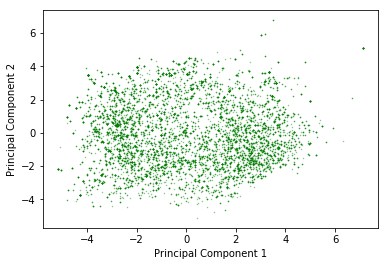

In [12]:
plt.figure(1, figsize=(6,4), )
ax = plt.scatter(pca_df.loc[:,0], pca_df.loc[:,1], color='g', alpha=.5, edgecolor='g', s=0.2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('Graphics/principal_comps.png',dpi=600)
plt.show()

In [13]:
explained = pca.explained_variance_ratio_
explained_sum = np.cumsum(explained)
eigenvector = np.array(range(1,24))

print(len(explained))
print(len(eigenvector))

23
23


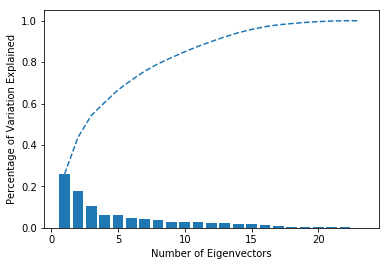

In [14]:
fig, ax = plt.subplots(1, figsize=(6,4))

ax.bar(eigenvector, explained)
ax.plot(eigenvector, explained_sum, '--')
ax.set_xlabel('Number of Eigenvectors')
ax.set_ylabel('Percentage of Variation Explained')

plt.savefig('Graphics/variation explained.png',dpi=600)
plt.show()

In [50]:
loadings = pd.DataFrame(pca.components_)

loadings.columns = features

loadings.to_csv('output/' + 'loadings.csv')

### Now we use the scores from the PCA to create clusters using kmeans

In [15]:
# Keep the top 10 principal components to use in clustering
print(principalComponents.shape)

y = principalComponents[:,0:10]

print(y.shape)

(10550, 23)
(10550, 10)


In [16]:
kmeans = KMeans(n_clusters=5).fit(y)

# Getting the cluster labels
labels = kmeans.predict(y)
print(len(labels))

10550


In [17]:
clusters = pd.DataFrame(labels, columns=['Cluster'])

In [18]:
#matpath = 'Matlab/' # select folder with data in it

#clusters = pd.read_csv(matpath + 'clusters.csv', header=None, names=['Cluster'], delimiter=',')

print(len(clusters))
clusters.head(10)

10550


,Cluster
0,1
1,1
2,1
3,1
4,1
5,1
6,3
7,1
8,3
9,0


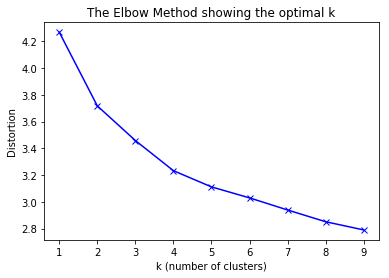

In [19]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(y)
    kmeanModel.fit(y)
    distortions.append(sum(np.min(cdist(y, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / y.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('Graphics/elbow.png',dpi=600)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.21726198103357522
For n_clusters = 3 The average silhouette_score is : 0.2136923828504166
For n_clusters = 4 The average silhouette_score is : 0.20977191370578052
For n_clusters = 5 The average silhouette_score is : 0.19742245385661047
For n_clusters = 6 The average silhouette_score is : 0.19408296814332696


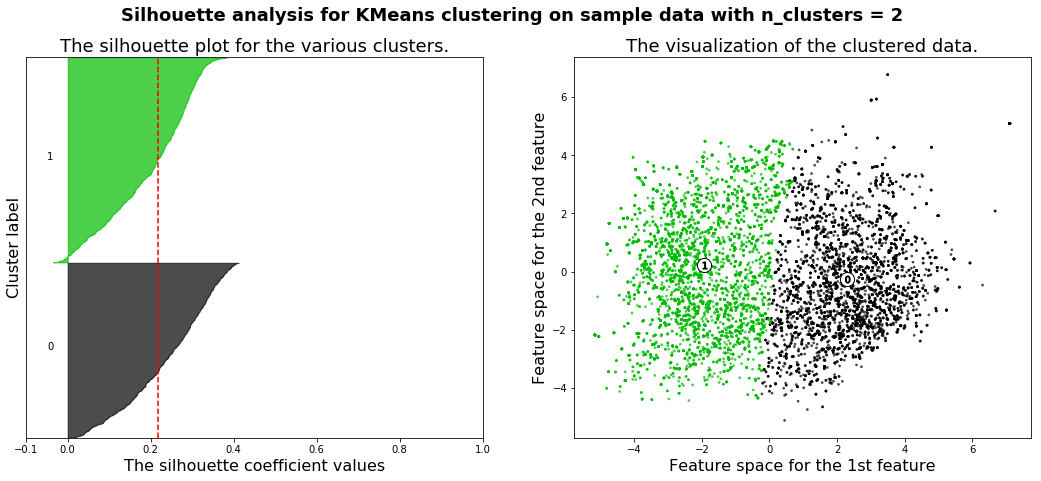

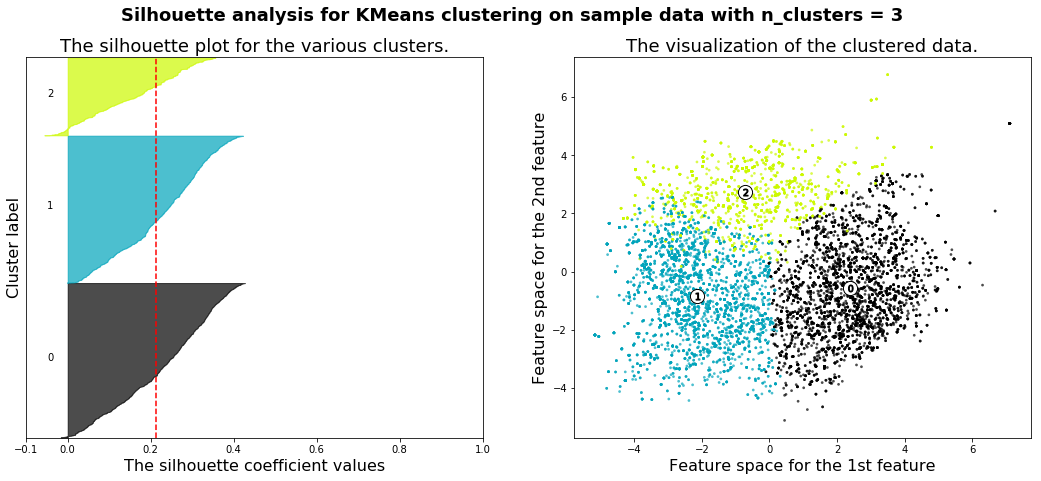

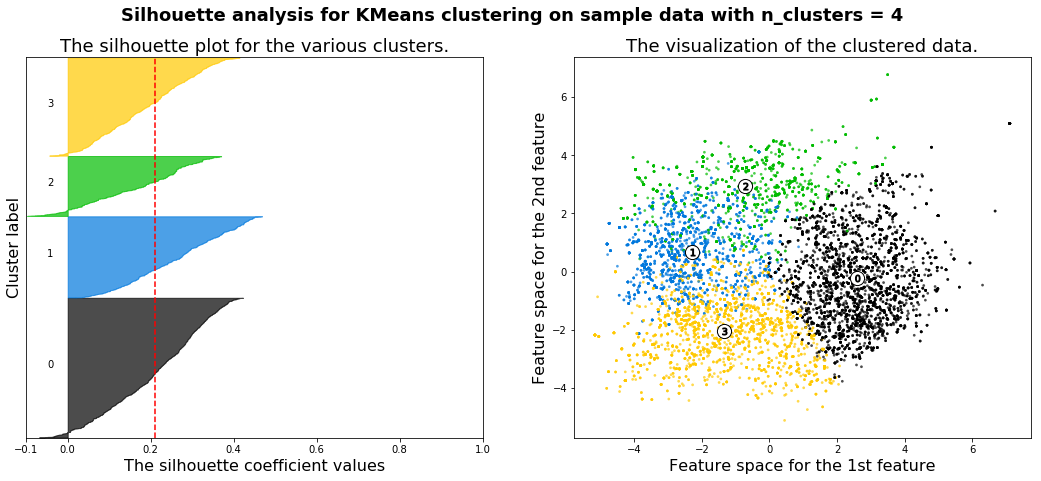

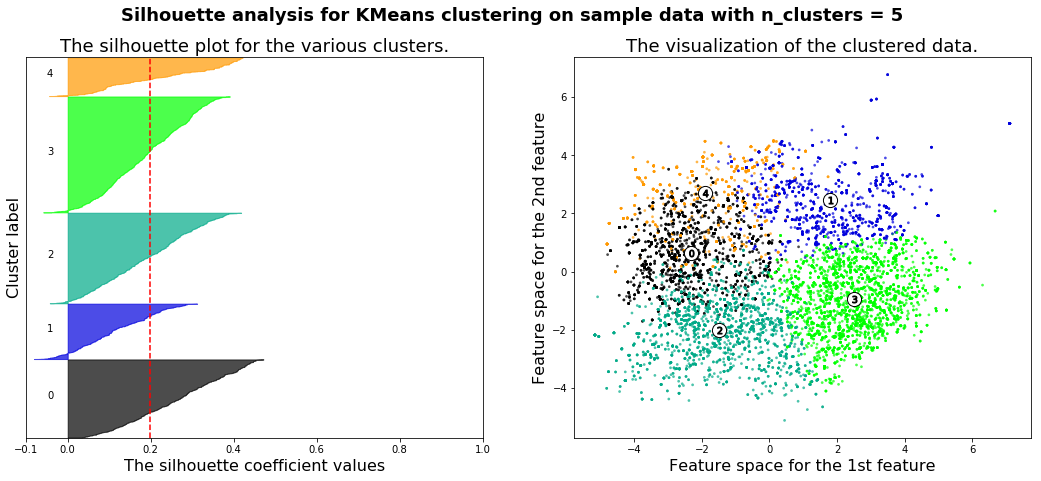

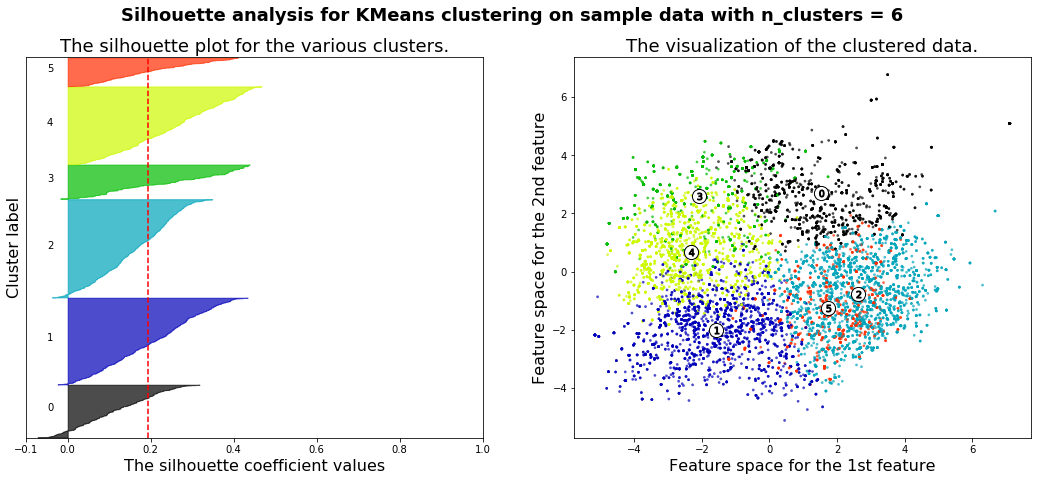

In [34]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(y) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(y)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(y, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(y, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize=18)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=16)
    ax1.set_ylabel("Cluster label", fontsize=16)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(y[:, 0], y[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.", fontsize=18)
    ax2.set_xlabel("Feature space for the 1st feature", fontsize=16)
    ax2.set_ylabel("Feature space for the 2nd feature", fontsize=16)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=18, fontweight='bold')
    plt.savefig('Graphics/silhouette %d.png' % n_clusters,dpi=600)

plt.show()

## Let's Try DBSCAN now!

Estimated number of clusters: 132
Estimated number of noise points: 8654


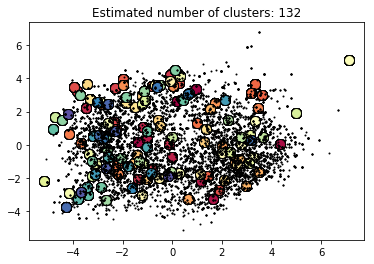

In [25]:
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(y)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = y[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1, linewidth=.1)
    
    xy = y[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10, linewidth=.1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.savefig('Graphics/dbscan.png',dpi=600)
plt.show()

### Next bring the station statistics that we ran PCA on back in. We'll merge the Cluster ID onto this and then calculate averages by cluster

In [26]:
outpath = 'Output/' # select folder with data in it

stats = pd.read_csv(outpath + 'stop_stats.csv', delimiter=',')

print(len(stats))
stats.head(2)

10550


,Unnamed: 0,key,total_pop,rent_comp,jobs,pct_rent,pct_white,pct_hispanic,pct_black,pct_asian,...,pct_smallmf,pct_bigmf,pct_medmf,pct_vacant,pct_since2000,pct_before1950,pct_bach_degree,pct_hh_kids,pct_unemp_civ,density
0,0,AC Transit1000340,4888.0,0.537709,1065622.0,0.764959,0.13216,0.04644,0.090221,0.684534,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986
1,1,AC Transit1000350,4888.0,0.537709,1065622.0,0.764959,0.13216,0.04644,0.090221,0.684534,...,0.056383,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986


In [27]:
stats_cluster = pd.concat([stats, clusters], axis=1, join_axes=[stats.index])

stats_cluster.head(2)

,Unnamed: 0,key,total_pop,rent_comp,jobs,pct_rent,pct_white,pct_hispanic,pct_black,pct_asian,...,pct_bigmf,pct_medmf,pct_vacant,pct_since2000,pct_before1950,pct_bach_degree,pct_hh_kids,pct_unemp_civ,density,Cluster
0,0,AC Transit1000340,4888.0,0.537709,1065622.0,0.764959,0.13216,0.04644,0.090221,0.684534,...,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986,2
1,1,AC Transit1000350,4888.0,0.537709,1065622.0,0.764959,0.13216,0.04644,0.090221,0.684534,...,0.773258,0.124849,0.064438,0.200967,0.328232,0.288792,0.126991,0.072036,18103.702986,2


In [28]:
cols2 = ['total_pop', 'pct_rent', 'pct_white', 'pct_hispanic',
       'pct_black', 'pct_asian', 'pct_below200pov', 'hispanic_pov',
       'black_pov', 'asian_pov', 'white_pov', 'pct_sfdetach', 'pct_smallmf',
       'pct_bigmf', 'pct_medmf', 'pct_vacant', 'pct_since2000',
       'pct_before1950', 'pct_bach_degree', 'pct_hh_kids', 'pct_unemp_civ',
       'density','rent_comp','jobs']

cluster_avgs=stats_cluster[cols2].groupby(stats_cluster['Cluster']).mean()

cluster_avgs.to_csv(outpath + 'cluster_avgs.csv')


In [29]:
stats_cluster['Cluster'].groupby(stats_cluster['Cluster']).count()

Cluster
0     963
1    3305
2    1557
3    2186
4    2539
Name: Cluster, dtype: int64

In [30]:
print(len(stats_cluster))

10550


In [34]:
stats_cluster.to_csv(output + 'stats_cluster.csv')

### Now we want to merge cluster ID back on to station geometry to create cluster maps

### RIGHT NOW THIS IS OBSOLETE

In [32]:
output = 'Output/'

dtypes = {'Stop ID': 'str', 'Name': 'str', 'Agency': 'str', 'OB Routes': 'str', 'IB Routes': 'str'}
rail_bus = pd.read_csv(output + 'rail_bus.csv', delimiter=',', dtype=dtypes)

print('rail_bus:',len(rail_bus))
print('stats_cluster:',len(stats_cluster))

station_cluster = pd.merge(stats_cluster, rail_bus, on='key', how="left")
print('station_cluster:',len(station_cluster))

station_cluster.head(2)

rail_bus: 10663
stats_cluster: 10550
station_cluster: 10550


,Unnamed: 0_x,key,total_pop,rent_comp,jobs,pct_rent,pct_white,pct_hispanic,pct_black,pct_asian,...,OB Routes,OB Saturday,OB Sunday,OB Weekday,Stop ID,Unnamed: 0.1,X,Y,index,station_area
0,0,AC Transit1000340,4888.0,0.537709,1065622.0,0.764959,0.13216,0.04644,0.090221,0.684534,...,"29, 19, 20",10.63,10.63,9.41,1000340,159,-122.272747,37.802268,70078.0,0.507711
1,1,AC Transit1000350,4888.0,0.537709,1065622.0,0.764959,0.13216,0.04644,0.090221,0.684534,...,96,30.00,30.00,30.97,1000350,1205,-122.271900,37.801843,71124.0,0.507711


In [33]:
station_cluster.to_csv(output + 'station_cluster.csv')